# Solar Radiation Prediction

Data analysis on a 4 months dataset collected at the HI-SEAS weather station (Hawaii). The observation sampling rate is 5 minutes and collected features/variables are:

- Solar radiation [W/m^2]
- Temperature [F]
- Atmospheric pressure [Hg]
- Humidity [%]
- Wind speed [miles/h]
- Wind direction [degrees]
- Time sun rise
- TIme sun set

The dataset is a time series with cyclicality(day) and seasonality(months). It is obvious that solar radiation is a function of duration of day light(among other features), thus we
will do time feature engineering in order to account for the relative time of day.

Goal is to train ML model to predict solar radiation as a function of the above features. Particulariy, we will establish a base line with a simple regression model and then we will use
assambles (Random Forest, Gradient Boosting) with Grid Search hyper-parameter tuning. R^2 and Mean-Squared-Error(MSE) used as model evaluation metrics. 

## Load dataset and Preperation

In [28]:
import pandas as pd
from datetime import datetime
from dateutil.tz import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [29]:
''' Import dataset and inspect observations(nan values) '''

df = pd.read_csv('solar_radiation_dataset.csv')
df.info()
print('\nCheck to nan/null')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB

Check to nan/null


UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

we need to set the correct timezone which is Hawaii Standard Zone(HSZ)

In [30]:
'''Convert column UNIXTime to datetime object and set correct Time zone. Data collected at HST, Hawaii Standard Zone'''

#Convert UNIX time to datetime object
# df['Date']= pd.to_datetime(data['UNIXTime'],unit='s')
df['Date'] = df['UNIXTime'].astype('datetime64[s]')
#Set time zone
df['Date'] = df['Date'].dt.tz_localize('UTC').dt.tz_convert('HST')

Feature 'Data' does not contain a valid Time of the day but only the correct Date of the observation. We will create two new columns, sunrise_time and sunset_time which will include the actual sun-set and sun-rise for specific day. Thus will combine parts of 'Data' with TimeSunRise and TimeSunSet respectevely.

Then we drop unnecessary columns (Data', 'Time', 'TimeSunRise', 'TimeSunSet)

In [31]:
''' Convert features TimeSunRise and TimeSunSet to include actual date of the observation '''

# #Holds actual observation time
df['Data'] = pd.to_datetime(df['Data']).dt.date

#Convert TimeSunRise and TimeSunSet features datetime.time objects
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise']).dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet']).dt.time

#Create new sunset/sunrise features with observation time
df['sunrise_time'] = df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunRise']), axis = 1)
df['sunset_time'] = df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunSet']), axis = 1)

#Correct timezone(HST)
df['sunrise_time'] = df['sunrise_time'].dt.tz_localize('HST')
df['sunset_time'] = df['sunset_time'].dt.tz_localize('HST')



#Set index
df.set_index('Date', inplace = True)

#Sort by index
df.sort_index()

#Drop unnecessary columns
df.drop(columns = ['Data', 'Time', 'TimeSunRise', 'TimeSunSet'], inplace = True)
df.head()

<ipython-input-31-50f14fe84313>:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['sunrise_time'] = df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunRise']), axis = 1)
<ipython-input-31-50f14fe84313>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['sunset_time'] = df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunSet']), axis = 1)


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,sunrise_time,sunset_time
Date,,,,,,,,,
2016-09-29 23:55:26-10:00,1475229326,1.21,48,30.46,59,177.39,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:50:23-10:00,1475229023,1.21,48,30.46,58,176.78,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:45:26-10:00,1475228726,1.23,48,30.46,57,158.75,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:40:21-10:00,1475228421,1.21,48,30.46,60,137.71,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:35:24-10:00,1475228124,1.17,48,30.46,62,104.95,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00


In this approach we assume(though reasonable assumption) that solar radiation is practically zero outsite of sun light period. Before Sunrise and After sunset. In order to validate this assumption, we will choose 5 random days from the dataset and plot the radiation as a function of time. 
We also add 2 vertical lines which denote the day light period.

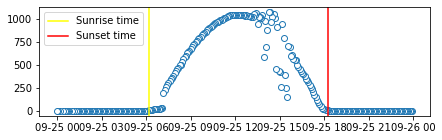

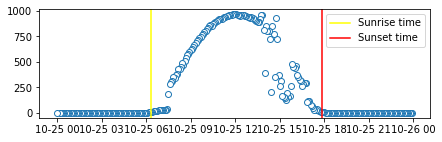

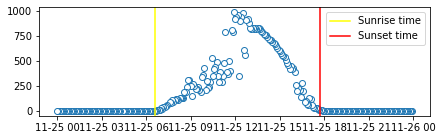

In [46]:
'''It is reasonable to expect that the solar radiation, for any  day, would be approximately zero before the sunrise and after the sunset time. 
Quick visualization check '''
df_random_days = [df.loc['2016-09-25':'2016-09-25',:], 
                    df.loc['2016-10-25':'2016-10-25',:],
                    df.loc['2016-11-25':'2016-11-25',:]]

for day in df_random_days:
    plt.figure(figsize = (7,2))
    plt.plot(day.Radiation, 'o', markerfacecolor = 'w')

    #Plotting vertical line at sunrise
    plt.axvline(day.sunrise_time.iloc[0], label = 'Sunrise time', color = 'yellow')

    #Plotting vertical line at sunset
    plt.axvline(day.sunset_time.iloc[0], label = 'Sunset time', color = 'red') 

    #Adjusting timezone of x-axis
    plt.gca().xaxis_date('HST')

    plt.legend()
    plt.show()


Above plots confirm the assumption as well the the correct manipulation of dates.

## Preliminary Analysis

We check range of each feature to see if they make sense, clean dataset.

In [12]:
''' Check ranges for each feature, see if the make sense '''
df.describe()


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


All values seem to make sense, though in feature Humidity we see that the max value is 103% but we choose to ignore it.

### Distribution of features

Understand how the each feature is allocated between their lower and upper limits.

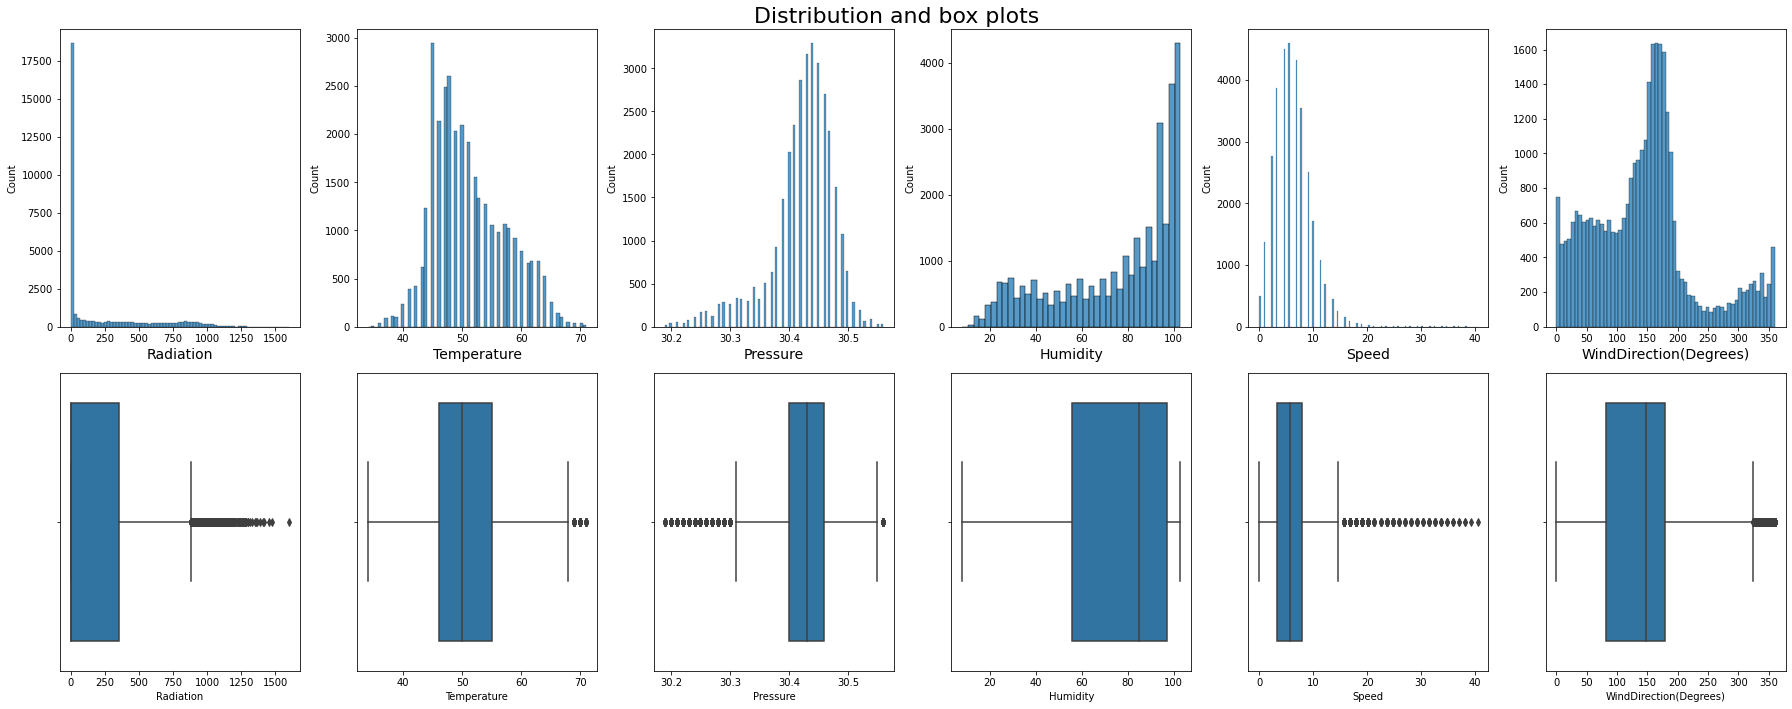

In [86]:
''' Check distribution of features '''
fig, ax = plt.subplots(nrows =2, ncols = 6, figsize = (25, 10))
features = ['Radiation', 'Temperature','Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']
index = 0

#Distribution
for feature in features:
    sns.histplot(x=df[feature], ax = ax[0,index])
    ax[0,index].set_xlabel(feature, fontsize = 14)
    index += 1

#Box plots
index = 0
for feature in features:
    sns.boxplot(x=df[feature], ax = ax[1,index])
    ax[0,index].set_xlabel(feature, fontsize = 14)
    index += 1
    

fig.suptitle('Distribution and box plots', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.show()

Explanation: throw NotImplementedException

## Feature Engineering

We consider that all features included in the dataset, are usefull for prediction of target value (Radiation).
We also need to take into account the time of the day as an indication because radiation heavily depends on solar position
on the sky and the duration of day light of each day.

We define 2 new features.
- Relative time of day (Rel_time) = $\frac{\text{Current time - Sunrise Time}}{\text{Sunrise Time - Sunset Time}}$
    - < 0 before sunrise
    - = 0 at sunrise
    - '>' 0 but < 1 between sunrise and sunset
    - = 1 at sunset
    - '>' 1 after sunset
    
- Solar day duration (Daylight_duration) = $\text{Sunrise Time - Sunset Time}$

In [49]:
df_engineered = df.copy()
#Converting sunrise and sunset times into timestamp
df_engineered['sunrise_timestamp'] = df_engineered.apply(lambda row: datetime.timestamp(row['sunrise_time']), axis = 1)
df_engineered['sunset_timestamp'] = df_engineered.apply(lambda row: datetime.timestamp(row['sunset_time']), axis = 1)

#Creating a column containing the number of daily light hours
df_engineered['Daylight_duration'] = (df_engineered['sunset_timestamp'] - df_engineered['sunrise_timestamp'])/60/60

#Creating column describing current time relative to sunrise/sunset
df_engineered['Rel_time'] = (df_engineered['UNIXTime']- df_engineered['sunrise_timestamp'])/(df_engineered['sunset_timestamp']-df_engineered['sunrise_timestamp'])

#Removing unnecessary features/columns
df_engineered.drop(columns = ['UNIXTime','sunrise_timestamp', 'sunset_timestamp', 'sunset_time', 'sunrise_time'], inplace = True)

df_engineered.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Daylight_duration,Rel_time
Date,,,,,,,,
2016-09-29 23:55:26-10:00,1.21,48,30.46,59,177.39,5.62,12.0,1.475602
2016-09-29 23:50:23-10:00,1.21,48,30.46,58,176.78,3.37,12.0,1.468588
2016-09-29 23:45:26-10:00,1.23,48,30.46,57,158.75,3.37,12.0,1.461713
2016-09-29 23:40:21-10:00,1.21,48,30.46,60,137.71,3.37,12.0,1.454653
2016-09-29 23:35:24-10:00,1.17,48,30.46,62,104.95,5.62,12.0,1.447778


## Features Correlation

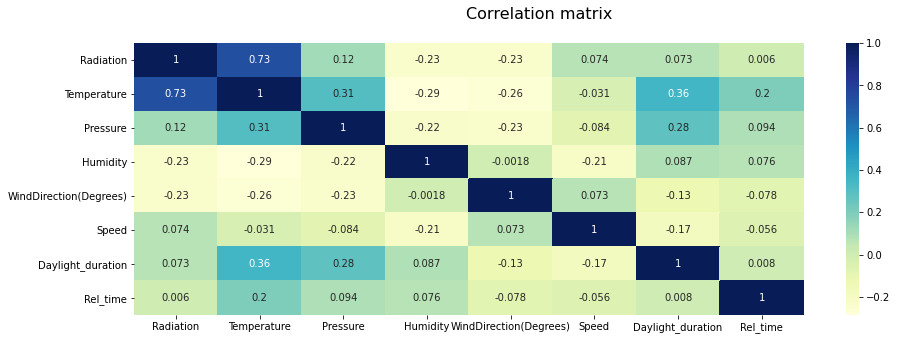

In [52]:
#Plotting a heatmap of the various features in the dataset
fig, ax = plt.subplots(figsize = (15,5))
sns.heatmap(df_engineered.corr(), annot = True, cmap = 'YlGnBu')
fig.suptitle('Correlation matrix', fontsize = 16)
plt.show()

Explanation: throw NotImplementedException

## Features scatter function of Radiation

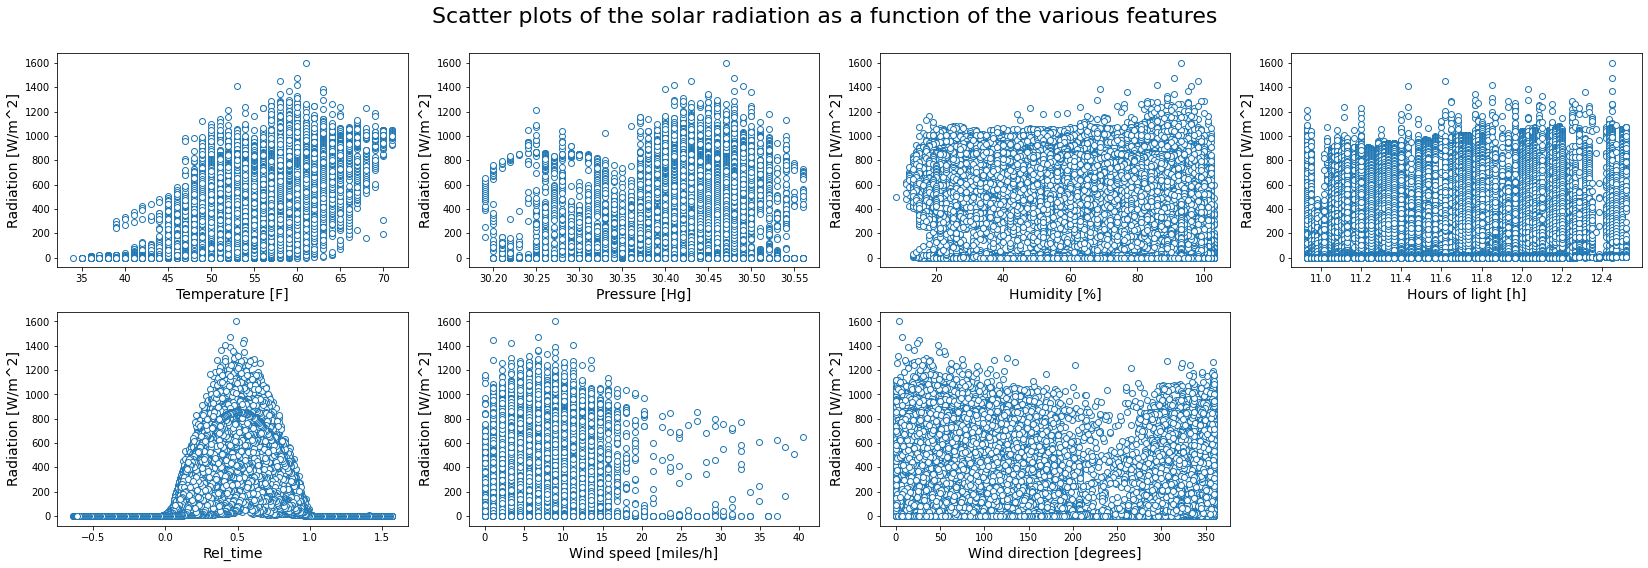

In [87]:
fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (23,8))

ax[0,0].plot(df_engineered.Temperature, df_engineered.Radiation,'o', markerfacecolor='w')
ax[0,0].set_xlabel('Temperature [F]', fontsize = 14)
ax[0,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,1].plot(df_engineered.Pressure, df_engineered.Radiation,'o', markerfacecolor='w')
ax[0,1].set_xlabel('Pressure [Hg]', fontsize = 14)
ax[0,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,2].plot(df_engineered.Humidity, df_engineered.Radiation,'o', markerfacecolor='w')
ax[0,2].set_xlabel('Humidity [%]', fontsize = 14)
ax[0,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,3].plot(df_engineered.Daylight_duration, df_engineered.Radiation,'o', markerfacecolor='w')
ax[0,3].set_xlabel('Hours of light [h]', fontsize = 14)
ax[0,3].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,0].plot(df_engineered.Rel_time, df_engineered.Radiation,'o', markerfacecolor='w')
ax[1,0].set_xlabel('Rel_time', fontsize = 14)
ax[1,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,1].plot(df_engineered.Speed, df_engineered.Radiation,'o', markerfacecolor='w')
ax[1,1].set_xlabel('Wind speed [miles/h]', fontsize = 14)
ax[1,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,2].plot(df_engineered['WindDirection(Degrees)'], df_engineered.Radiation,'o', markerfacecolor='w')
ax[1,2].set_xlabel('Wind direction [degrees]', fontsize = 14)
ax[1,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

fig.delaxes(ax[1,3])

fig.suptitle('Scatter plots of the solar radiation as a function of the various features', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.show()

Positive linear correlation with temperature 
Seems there is a correlation between radiation peak values with pressure peak values.

## Models

We are going to set a baseline with a simple linear model and will use RandomForest and GradientBoosting with GridSearch to get better results.

Evaluation metrics:
- R^2
- Mean Squared Error (MSE)

## Linear Regression

Split data to train(70%) and test(30%)

In [88]:
df = df_engineered
#Splitting dataset into labels and features
X = df.drop(columns = 'Radiation')
y = df.Radiation
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size = 0.3,
                                                   random_state = 42)

In [89]:
#Initiating linear regression model
lr = LinearRegression()

#Training the linear regression model
lr.fit(X_train, y_train)

#Carrying out prediction with the linear model
lr_predict_train = lr.predict(X_train)
lr_predict_test = lr.predict(X_test)

In [90]:
#Performance of the linear model

#Squared error
print('Linear model, R^2 training set:{:.2f}'.format(r2_score(y_train, lr_predict_train)))
print('Linear model, R^2 test set:{:.2f}'.format(r2_score(y_test,lr_predict_test)))

#Mean squared error (MSE)
print('Simple Linear model, MSE training set:{:.2f}'.format(MSE(y_train, lr_predict_train)))
print('Simple Linear model, MSE test set:{:.2f}'.format(MSE(y_test,lr_predict_test)))

Linear model, R^2 training set:0.62
Linear model, R^2 test set:0.61
Simple Linear model, MSE training set:37816.47
Simple Linear model, MSE test set:38464.32


R^2 in both training and test is similar, indicating that there are no overfitting issues

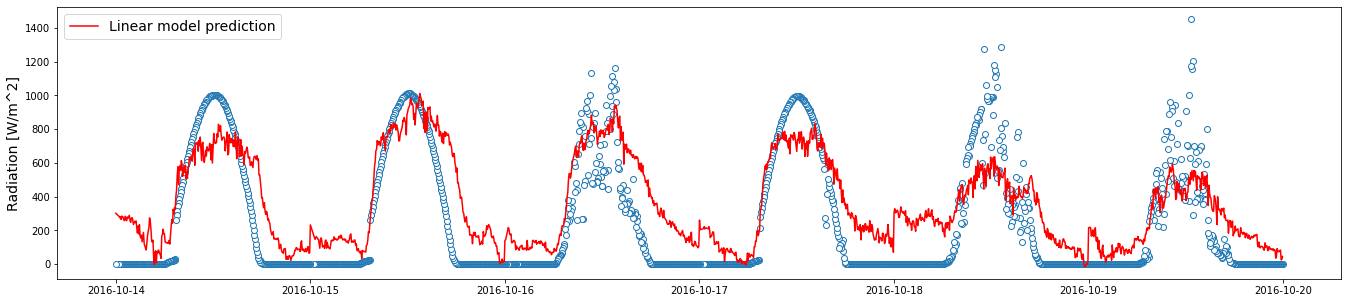

In [58]:
#Visual representation, predictions with linear model for the 5-day period
df_5 = df_engineered.loc['2016-10-14':'2016-10-19',:]
X_5 = df_5.drop(columns = 'Radiation')
y_pred_5 = lr.predict(X_5)


fig, ax = plt.subplots(figsize = (23,5))    

ax.plot(df_5.Radiation,'o', markerfacecolor='w')
ax.plot(df_5.index, y_pred_5, linewidth = 1.5, color = 'red', label = 'Linear model prediction')
ax.set_ylabel('Radiation [W/m^2]', fontsize = 14)
ax.legend(fontsize = 14)

plt.show()

It seems that linear model is doing ok predicting radiation during day light as this was suggested by the relatively high R^2. Though, it is performing poorly during night hours.

## Tree-based models

We will use two tree-based models.
- Random Forest
- Gradient Boosting

These models are ensamble models thus hyper-parameters tuning is required for better predictions.  Multiple models are trained as a way to identify the best performing set of hyper-parameters. We will use GridSearchCV.

In [129]:
def print_scores(model_name, MSE_CV, y_train, y_test, y_pred_train, y_pred_test):
    print(model_name)

    #Computing the MSE in the traning set, test set, and cross-validation procedure
    
    print('\tCV MSE:{:.2f}'.format(MSE_CV.mean()))
    print('\tTrain MSE:{:.2f}'.format(MSE(y_train, y_pred_train)))
    print('\tTest MSE:{:.2f}'.format(MSE(y_test, y_pred_test)))
    
    #Computing the R^2 in the traning set and test set 
    print('\tR^2 score training set:{:.2f}'.format(r2_score(y_train, y_pred_train)))
    print('\tR^2 score test set:{:.2f}'.format(r2_score(y_test, y_pred_test)))
    

### Random Forest

In [91]:
#Initiating Random Forest regressor
rf_model = RandomForestRegressor(random_state = 100)

#Define the grid of hyperparameters
# 'n_estimators': [500, 600, 700],
params_rf = {
    'n_estimators': [10],
    'max_depth': [5, 6, 7],
    'min_samples_leaf': [0.075, 0.05, 0.025],
    'max_features': ['log2', 'sqrt']   
}


#Initiate Grid search
grid_rf = GridSearchCV(estimator = rf_model,
                       param_grid = params_rf,
                       cv = 3,
                       scoring = 'neg_mean_squared_error',
                       verbose = 1,
                       n_jobs = 4)

In [92]:
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:    5.4s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=100), n_jobs=4,
             param_grid={'max_depth': [5, 6, 7],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.075, 0.05, 0.025],
                         'n_estimators': [10]},
             scoring='neg_mean_squared_error', verbose=1)

In [93]:
#Extracting best hyperparameters
rf_best_hyperparams = grid_rf.best_params_
print('Best hyperparameters for RF: \n', rf_best_hyperparams)

#Extracting best rf model
rf = grid_rf.best_estimator_

Best hyperparameters for RF: 
 {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.025, 'n_estimators': 10}


In [94]:
#Check if there is overfitting through the use of Cross validation
rf_MSE_CV = -cross_val_score(rf, X_train, y_train,
                            cv = 10, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1)

In [95]:
#Compute Random Forest predictions in the traning and test sets
rf_predict_train = rf.predict(X_train)
rf_predict_test = rf.predict(X_test)

In [121]:
#Print scores
print_scores(type(rf).__name__, rf_MSE_CV, y_train, y_test, rf_predict_train, rf_predict_test)

RandomForestRegressor
	CV MSE:25676.63
	Train MSE:24999.78
	Test MSE:25388.94
	R^2 score training set:0.75
	R^2 score test set:0.75


### Gradient Boost

In [122]:
#Initiating Gradient Boosting regressor
gb_model = GradientBoostingRegressor(random_state = 42)

#Define the grid of hyperparameters
# 'n_estimators': [200, 300, 600],
params_gb = {
    'n_estimators': [10],
    'max_depth': [2, 3, 5],
    'min_samples_leaf': [0.125, 0.1, 0.075],
    'max_features': ['log2', 'sqrt']   
}


#Initiate Grid search
grid_gb = GridSearchCV(estimator = gb_model,
                       param_grid = params_gb,
                       cv = 3,
                       scoring = 'neg_mean_squared_error',
                       verbose = 1,
                       n_jobs = 4)

In [123]:
#Fitting the grid search
grid_gb.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:    2.2s finished


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.125, 0.1, 0.075],
                         'n_estimators': [10]},
             scoring='neg_mean_squared_error', verbose=1)

In [124]:
#Extracting best hyperparameters
gb_best_hyperparams = grid_gb.best_params_
print('Best hyperparameters for GB: \n', gb_best_hyperparams)

Best hyperparameters for GB: 
 {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.075, 'n_estimators': 10}


In [125]:
#Extracting best gb model
gb = grid_gb.best_estimator_

In [126]:
#Checking if there is overfitting through the use of Cross validation
gb_MSE_CV = -cross_val_score(gb, X_train, y_train,
                            cv = 10, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1)

In [132]:
#Computing Gradient Boosting predictions on the train and test stes
gb_predict_train = gb.predict(X_train)
gb_predict_test = gb.predict(X_test)


In [133]:
#Print scores
print_scores(type(gb).__name__, gb_MSE_CV, y_train, y_test, gb_predict_train, gb_predict_test)


GradientBoostingRegressor
	CV MSE:39476.45
	Train MSE:39238.18
	Test MSE:39967.77
	R^2 score training set:0.61
	R^2 score test set:0.60


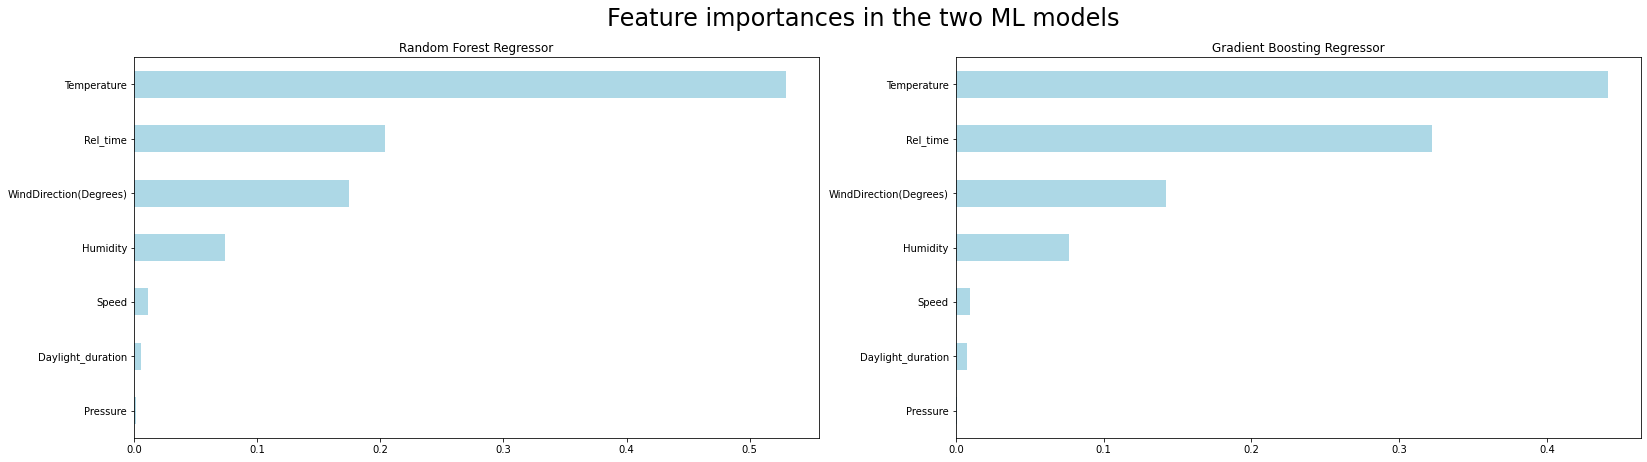

In [134]:
#Plotting feature importances for Random Forest and Gradient boosting

#Creating a pd.Series of feature importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
importances_gb = pd.Series(gb.feature_importances_, index = X.columns)

#Sorting importances
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_gb = importances_gb.sort_values()

#Plotting sorted importances
fig, ax = plt.subplots(ncols = 2, figsize = (27,7))
sorted_importances_rf.plot(kind = 'barh', color = 'lightblue', ax = ax[0])
sorted_importances_gb.plot(kind = 'barh', color = 'lightblue', ax = ax[1])
ax[0].set_title('Random Forest Regressor')
ax[1].set_title('Gradient Boosting Regressor')
fig.suptitle('Feature importances in the two ML models', fontsize = 24)
plt.show()

## Conclusions

throw NotImplementedException